# HM04 - Applied ML

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
#Load the data
data = pd.read_csv("CrowdstormingDataJuly1st.csv")

In [3]:
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [4]:
list(data.columns.values)

['playerShort',
 'player',
 'club',
 'leagueCountry',
 'birthday',
 'height',
 'weight',
 'position',
 'games',
 'victories',
 'ties',
 'defeats',
 'goals',
 'yellowCards',
 'yellowReds',
 'redCards',
 'photoID',
 'rater1',
 'rater2',
 'refNum',
 'refCountry',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

## 0. (Basic) Data Cleaning

### 0.1 NaN Values

In [5]:
def columns_nanValues(data):
    # print all columns with at least one NaN value
    l = list()
    for c in data:
        if data[c].hasnans:
            l.append(c)
    return l

columns_nanValues(data)

['height',
 'weight',
 'position',
 'photoID',
 'rater1',
 'rater2',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

Some columns contains NaN values. For this homework, we will not be able to work with data having no *skin color* feature. Therefore we only keep instances with this information.

In [6]:
# We remove all instance with no 'photoID' information, since the skin color needs this information
data_clean = data[~data.photoID.isnull()]
nan_col = columns_nanValues(data_clean)
nan_col

['height',
 'weight',
 'position',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp']

In [7]:
data_clean[nan_col].dtypes

height      float64
weight      float64
position     object
Alpha_3      object
meanIAT     float64
nIAT        float64
seIAT       float64
meanExp     float64
nExp        float64
seExp       float64
dtype: object

In [8]:
print("Number of NaNs values per column:")
for x in nan_col:
    print(x, '-->', data_clean[x].isnull().sum())

Number of NaNs values per column:
height --> 46
weight --> 753
position --> 8461
Alpha_3 --> 1
meanIAT --> 153
nIAT --> 153
seIAT --> 153
meanExp --> 153
nExp --> 153
seExp --> 153


For the values related to the *IAT* and *Exp*, we decided to remove those rows, since they are, for us, the more relevant of all in relation to a possible racism from refs to players.

In [9]:
data_clean = data_clean[~data_clean.nIAT.isnull()]
columns_nanValues(data_clean)

['height', 'weight', 'position']

We know that there is multiple entries per player in our dataset. Therefore, is it possible that the information about *weight* or *height* for a player is missing in one entry but present in another ? If yes, we could simply replace the missing values by the ones present in another row, but as we can see, such case doesn't occur. Therefore, setting this values to -1 seems to be appropriate.

In [10]:
# Assert than the missing WEIGHT value for a player
# is not present in another row

data_noWeight = data_clean[data_clean.weight.isnull()]
data_withWeight = data_clean[~data_clean.weight.isnull()]

i1 = list(data_noWeight.index)
i2 = list(data_withWeight.index)

[x for x in i1 if x in i2]

[]

In [11]:
# Assert than the missing HEIGHT value for a player
# is not present in another row

data_noHeight = data_clean[data_clean.height.isnull()]
data_withHeight = data_clean[~data_clean.height.isnull()]

i1 = list(data_noHeight.index)
i2 = list(data_withHeight.index)

[x for x in i1 if x in i2]

[]

Now there is only three features with NaN values. For the colums of type *object* (position feature), we deciced tonreplace the NaN values by "Unknown".

For the type *float64*, we have decided to replace it by the -1 value. We choose this value since we are sure than none other cell has it.

In [12]:
# Assert than -1 is never used
(data_clean == -1).sum().sum()

0

In [13]:
# 'object' columns
object_col = data_clean[nan_col].select_dtypes(include=['object']).columns
data_clean[object_col] = data_clean[object_col].fillna("Unknoww")

# 'float64' columns
object_col = data_clean[nan_col].select_dtypes(include=['float64']).columns
data_clean[object_col] = data_clean[object_col].fillna(-1)

In [14]:
# Assert no more "NaN" values
columns_nanValues(data_clean)

[]

NB: Another possibility would be to simply remove all rows containing NaN values in the height/weight columns. We decided to go for another option because, for us, this two features are not the more relevant for this problem.

### 0.2 SkinColor feature

The *skin color* feature is stored in two columns: *rater1* and *rater2*. Based on these two columns, we create a new feature *skinColor* by aggregating the two results. But before, let's take a look on the raters results.

In [15]:
data_skin = data_clean
data_skin["skinColorDiff"] = (data_skin.rater1-data_skin.rater2).abs()

It's obvious that they aren't always on the same page, therefore it is natural to have different results for the same player.
But there is something that we found strange

In [16]:
data_colorDiff = data_skin[data_skin.skinColorDiff > 0.25]
len(data_colorDiff)

164

For 164 entries, the two raters are really not on the same page.

In [17]:
print(data_colorDiff.rater1.unique())
print(data_colorDiff.rater2.unique())

[ 0.]
[ 0.5]


When one rater consider the player's skin as *very light sking* and the other as *neither dark not light skin*, we decided that these entries aren't reliable and therefore remove it.

In [18]:
data_skin_clean = data_skin[data_skin.skinColorDiff <= 0.25]
len(data_skin_clean)

124304

In [19]:
# Add the skin color based on the two raters
data_skin_clean["skinColor"] = (data_skin.rater1+data_skin.rater2)/2

/home/danny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [20]:
data = data_skin_clean
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skinColorDiff,skinColor
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.25,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.00,0.750
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.25,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.25,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,1.000


## 1.
>Train a sklearn.ensemble.RandomForestClassifier that given a soccer player description outputs his skin color. Show how different parameters passed to the Classifier affect the overfitting issue. Perform cross-validation to mitigate the overfitting of your model. Once you assessed your model, inspect the feature_importances_ attribute and discuss the obtained results. With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different feature_importances_ attribute?

### 1.1 Features aggregation
For this first part, we only care about player description. Therefore, we need to keep only one entry per player and for each player to aggregate his data with all refs with who he has a dyad.

In [21]:
data_by_player = data.groupby('playerShort')
data_player = data_by_player.agg({
        # Keep only one entry per player
        'player'    : 'first',
        'club'      : 'first',
        'leagueCountry' : 'first',
        'birthday'  : 'first',
        'position'  : 'first',
        'height'    : 'mean',
        'weight'    : 'mean',
        'skinColor' : 'mean',
        
        # Sum all referees data
        'games'     : 'sum',
        'victories' : 'sum',
        'ties'      : 'sum',
        'defeats'   : 'sum',
        'goals'     : 'sum',
        'yellowCards' : 'sum',
        'yellowReds': 'sum',
        'redCards'  : 'sum',
        
        'meanIAT'   : 'mean',
        'meanExp'   : 'mean',
        'seIAT'     : 'mean',
        'seExp'     : 'mean'
    })

data_player.head()

,skinColor,seIAT,meanExp,club,ties,birthday,meanIAT,seExp,redCards,yellowCards,victories,defeats,yellowReds,position,weight,games,goals,height,leagueCountry,player
playerShort,,,,,,,,,,,,,,,,,,,,
aaron-hughes,0.125,0.000652,0.494575,Fulham FC,179,08.11.1979,0.346459,0.004065,0,19,247,228,0,Center Back,71.0,654,9,182.0,England,Aaron Hughes
aaron-hunt,0.125,0.000219,0.449220,Werder Bremen,73,04.09.1986,0.348818,0.000993,1,42,141,122,0,Attacking Midfielder,73.0,336,62,183.0,Germany,Aaron Hunt
aaron-lennon,0.250,0.000367,0.491482,Tottenham Hotspur,97,16.04.1987,0.345893,0.002032,0,11,200,115,0,Right Midfielder,63.0,412,31,165.0,England,Aaron Lennon
aaron-ramsey,0.000,0.003334,0.514693,Arsenal FC,42,26.12.1990,0.346821,0.013522,1,31,150,68,0,Center Midfielder,76.0,260,39,178.0,England,Aaron Ramsey
abdelhamid-el-kaoutari,0.250,0.001488,0.335587,Montpellier HSC,40,17.03.1990,0.331600,0.005296,2,8,41,43,4,Center Back,73.0,124,1,180.0,France,Abdelhamid El-Kaoutari


There is still some columns that we can aggregate from the original dataset. We decided to combine the *meanIAT* and *meanExp* together, and the *seIAT* with the *seExp*.

In [22]:
data_player["meanIATEXP"] = (data_player.meanIAT + data_player.meanExp) / 2
data_player["seIATEXP"] = (data_player.seIAT**2 + data_player.seExp**2)**0.5
# TRY WITH https://www.researchgate.net/post/How_do_I_combine_mean_and_standard_deviation_of_two_groups
data_player.head()


# For me it doesn't make a lot of sense what I'm doing here... 
# I first sum all IAT and Exp for a player but by differents ref...
# but I don't see another "aggregating" way...

,skinColor,seIAT,meanExp,club,ties,birthday,meanIAT,seExp,redCards,yellowCards,...,yellowReds,position,weight,games,goals,height,leagueCountry,player,meanIATEXP,seIATEXP
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,0.125,0.000652,0.494575,Fulham FC,179,08.11.1979,0.346459,0.004065,0,19,...,0,Center Back,71.0,654,9,182.0,England,Aaron Hughes,0.420517,0.004117
aaron-hunt,0.125,0.000219,0.449220,Werder Bremen,73,04.09.1986,0.348818,0.000993,1,42,...,0,Attacking Midfielder,73.0,336,62,183.0,Germany,Aaron Hunt,0.399019,0.001017
aaron-lennon,0.250,0.000367,0.491482,Tottenham Hotspur,97,16.04.1987,0.345893,0.002032,0,11,...,0,Right Midfielder,63.0,412,31,165.0,England,Aaron Lennon,0.418687,0.002065
aaron-ramsey,0.000,0.003334,0.514693,Arsenal FC,42,26.12.1990,0.346821,0.013522,1,31,...,0,Center Midfielder,76.0,260,39,178.0,England,Aaron Ramsey,0.430757,0.013927
abdelhamid-el-kaoutari,0.250,0.001488,0.335587,Montpellier HSC,40,17.03.1990,0.331600,0.005296,2,8,...,4,Center Back,73.0,124,1,180.0,France,Abdelhamid El-Kaoutari,0.333593,0.005501


### 1.2 Convert columns types

As seen previously, some of our columns have the *object* type. Since the library we are using doesn't deal with this type of column values, we need to change it by using a *LabelEncoder()*

In [23]:
from sklearn import preprocessing
def columnEncoder(df, col):
    """
    Replace all values of a column by applying the 'LabelEncoder' form 'sklearn'
    
    INPUT:
        df: The dataframe containing the columns to change
        col: The column name over which the 'LabelEncoder' will be applied
        
    OUTPUT:
        The dataframe with news values in the specified column
    """
    labelEncoder = preprocessing.LabelEncoder()
    df[col] = labelEncoder.fit_transform(df[col])

In [24]:
data_player.dtypes

skinColor        float64
seIAT            float64
meanExp          float64
club              object
ties               int64
birthday          object
meanIAT          float64
seExp            float64
redCards           int64
yellowCards        int64
victories          int64
defeats            int64
yellowReds         int64
position          object
weight           float64
games              int64
goals              int64
height           float64
leagueCountry     object
player            object
meanIATEXP       float64
seIATEXP         float64
dtype: object

In [25]:
# Convert all columns with type 'object'
col_object = data_player.dtypes == 'object'
for col in data_player.loc[:,col_object]:
    columnEncoder(data_player, col)

Now all the columns are numbers, but we have decided to work have only *float64* values.

In [26]:
data_player = data_player.astype(float)
data_player.dtypes

skinColor        float64
seIAT            float64
meanExp          float64
club             float64
ties             float64
birthday         float64
meanIAT          float64
seExp            float64
redCards         float64
yellowCards      float64
victories        float64
defeats          float64
yellowReds       float64
position         float64
weight           float64
games            float64
goals            float64
height           float64
leagueCountry    float64
player           float64
meanIATEXP       float64
seIATEXP         float64
dtype: object

### 1.3 Prepare data for ML

In [27]:
X_columns = ["club", "leagueCountry", "birthday", "height", 
             "weight", "position", "games",
             "victories", "ties", "defeats", "goals", 
             "yellowCards", "yellowReds", "redCards",
             "meanIATEXP", "seIATEXP"]

X = data_player[X_columns]

The assignement asked us to use the *RandomForestClassifier*. Therefore, we need to work with discrete values. We've decided to add a new column to our data: *isBlack*. This column takes the value *True* if the *skinColor* average of the two raters is bigger than 0.5.

Note that if *isBlack* is false, it doesn't mean that the player has light skin (can be *neither dark nor light skin*).

In [28]:
data_player['isBlack'] = data_player["skinColor"] > 0.5
y = data_player['isBlack']

### 1.4 Random Forest Classifier - Assert model

As specified in the assignement, we use *cross-validation* with the *radom forest classifier* to perform our prediction, therefore mitigating the overfitting of the model.

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

We start by choosing the best parameters for our classifier. We've decided to tune two parameters of the scikit RandomForestClassifier:
- n_estimators
- max_features

Due to the randomness that we encounter by using this code, we select the best parameters by averaging the result after a five-loop iteration.

#### 1.4.1 n_estimators

In [30]:
k_range = range(1,40)
k_scores = [0] * 39

for j in range(5):
    for i in k_range:
        ml = RandomForestClassifier(n_estimators=i)
        cross = (cross_val_score(ml, X, y, cv=10))
        
        k_scores[i-1] += cross.mean()

35 0.852086348555


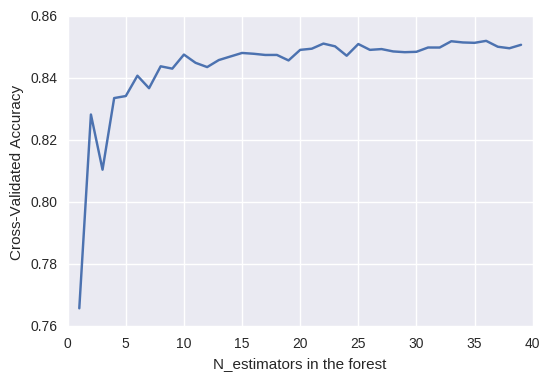

In [31]:
max_scores = -1
best_n = -1

scores = list()
for i,x in enumerate(k_scores):
    score = x / 5
    scores.append(score)
    if score > max_scores:
        max_scores = score
        best_n = i

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)        
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(k_range, scores)
plt.xlabel('N_estimators in the forest')
plt.ylabel('Cross-Validated Accuracy')


# Best values
print(best_n, max_scores)

#### 1.4.2 max_features

In [32]:
max_features = range(1,17)
k_scores = [0] * 16

for j in range(5):
    for i in max_features:
        ml = RandomForestClassifier(max_features=i)
        cross = (cross_val_score(ml, X, y, cv=10))
    
        k_scores[-1] += cross.mean()

15 3.2


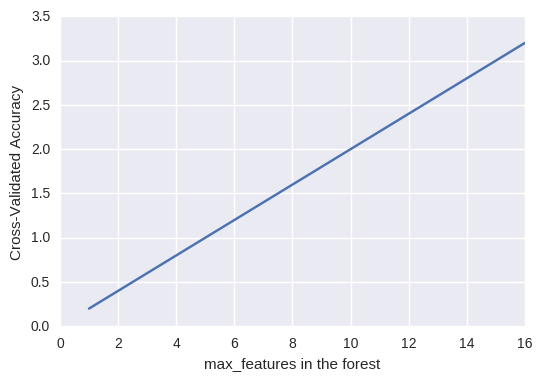

In [33]:
max_scores = -1
best_n = -1

scores = list()
for i,x in enumerate(max_features):
    score = x / 5
    scores.append(score)
    if score > max_scores:
        max_scores = score
        best_n = i

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)        
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(max_features, scores)
plt.xlabel('max_features in the forest')
plt.ylabel('Cross-Validated Accuracy')


# Best values
print(best_n, max_scores)

#### 1.4.3 features_importances

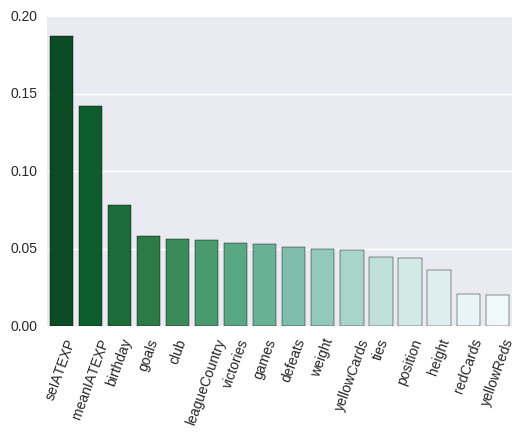

In [34]:
ml = RandomForestClassifier(n_estimators=27, max_features=15)
ml.fit(X,y)
feature_importance = ml.feature_importances_

# Combining the features_importance array with the corresponding feature name
l1 = list(zip(feature_importance, X.columns))
l1.sort(key=lambda x: x[0], reverse=True)
features = list(map(lambda x: x[0], l1))
features_names = list(map(lambda x: x[1], l1))

# Plot the features_importances graph
graph = sns.barplot(features_names, features, palette='BuGn_r')
graph.set_xticklabels(labels=features_names, rotation=70)
plt.show()

As expected, the features with the most importance are **meanIATEXP** and **seIATEXP**. It makes sens since these two features are directly linked with the player skin color question.

The **birthday** importance does also make sense. Indeed, it is probable that the youger and older player are white in the four leagues analyzed. A younger player is probably issued for the club formation center and since we deal with european leagues, the probably of lighter skin is higher. On the other side, it is common for footballers to end their career in their home country. Therefore, the oldest a player is, the higher chance to be white.

WHAT ABOUT THE OTHERS ???

## 2.

>Aggregate the referee information grouping by soccer player, and use an unsupervised learning technique to cluster the soccer players in 2 disjoint clusters. Remove features iteratively, and at each step perform again the clustering and compute the silhouette score -- can you find a configuration of features with high silhouette score where players with dark and light skin colors belong to different clusters? Discuss the obtained results.

### 2.1 Remove useless referees

Now we need to look a little more into the referees features. As mentionned in the complementary reading for this assignement, there is some referees in this dataset who have less than 22 dyads. Since we want to take into consideration only games in the four leagues (England, France, Germany, and Spain), we need to remove all dyads where a referee has less that 22 games. Note that these doesn't mean we remove all possible noise of our data.

In [35]:
# Group the data by refs
data_by_refs = data.groupby('refNum').size()
refsToKeep = data_by_refs >= 22

# Retrieve the 'refNum' of refs to keep in the data
refsToKeepID = list()
for i,x in enumerate(refsToKeep):
    if x:
        refsToKeepID.append(refsToKeep.index[i])

# Keep only the refs with at least 22 games
data_refs = data[data.refNum.isin(refsToKeepID)]
data_refs.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skinColorDiff,skinColor
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.25,0.125
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.25,0.125
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,1.000
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,0.250
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.00,0.000


### 2.2 Group by player

Now that we clean a little bit the refs information, we can group the data by soccer player. We need to perform the aggregation in the same way as for the first part of this assignement. But here, we decided to remove directly some useless features.

In [36]:
list(data_refs.columns)

['playerShort',
 'player',
 'club',
 'leagueCountry',
 'birthday',
 'height',
 'weight',
 'position',
 'games',
 'victories',
 'ties',
 'defeats',
 'goals',
 'yellowCards',
 'yellowReds',
 'redCards',
 'photoID',
 'rater1',
 'rater2',
 'refNum',
 'refCountry',
 'Alpha_3',
 'meanIAT',
 'nIAT',
 'seIAT',
 'meanExp',
 'nExp',
 'seExp',
 'skinColorDiff',
 'skinColor']

- **player**: The *playerShort* feature is enough, no need to keep players names
- **photoID**: irrelevant
- **rater1**: Skin information stored in *skinColor* column
- **rater2**: Skin information stored in *skinColor* column
- **refNum**: Multiple refs merge together, makes no sens to aggregate here.
- **refCountry**, **Alpha_3**, **meanIAT**,**nIAT**, **seIAT**, **meanExp**,**nExp**, **seExp**: Sames as *refNum*.
- **skinColorDiff**: Not useful anymore

In [37]:
features_drop = ['player', 'photoID', 'rater1', 'rater2', 
                 'refNum', 'refCountry', 'Alpha_3', 'meanIAT',
                 'nIAT', 'seIAT', 'meanExp','nExp','seExp',
                 'skinColorDiff']

data_of_interest = data_refs.drop(features_drop, axis=1)
data_of_interest.head()

,playerShort,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,skinColor
5,aaron-hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0,0,0,0.125
6,aleksandar-kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0,0,0,0,0.125
7,alexander-tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0,0,0,0,1.000
8,anders-lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,1,0,0,0,0,0,0.250
9,andreas-beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,0,0,0,0,0,0,0.000


In [38]:
data_by_player = data_of_interest.groupby('playerShort')
data_player = data_by_player.agg({
        # Keep only one entry per player
        'club'      : 'first',
        'leagueCountry' : 'first',
        'birthday'  : 'first',
        'position'  : 'first',
        'height'    : 'mean',
        'weight'    : 'mean',
        'skinColor' : 'mean',
        
        # Sum referees data
        'games'     : 'sum',
        'victories' : 'sum',
        'ties'      : 'sum',
        'defeats'   : 'sum',
        'goals'     : 'sum',
        'yellowCards' : 'sum',
        'yellowReds': 'sum',
        'redCards'  : 'sum',
    })

data_player.head()

,skinColor,club,ties,birthday,redCards,yellowCards,victories,leagueCountry,yellowReds,position,weight,games,goals,height,defeats
playerShort,,,,,,,,,,,,,,,
aaron-hughes,0.125,Fulham FC,174,08.11.1979,0,19,240,England,0,Center Back,71.0,635,8,182.0,221
aaron-hunt,0.125,Werder Bremen,70,04.09.1986,1,39,139,Germany,0,Attacking Midfielder,73.0,328,59,183.0,119
aaron-lennon,0.250,Tottenham Hotspur,96,16.04.1987,0,11,200,England,0,Right Midfielder,63.0,411,31,165.0,115
aaron-ramsey,0.000,Arsenal FC,42,26.12.1990,1,31,144,England,0,Center Midfielder,76.0,253,39,178.0,67
abdelhamid-el-kaoutari,0.250,Montpellier HSC,40,17.03.1990,2,8,41,France,4,Center Back,73.0,124,1,180.0,43


### 2.3 Prepare data for ML

#### 2.3.1 Numerical values only

Our datasets has, at the moment, different types per column

In [39]:
data_player.dtypes

skinColor        float64
club              object
ties               int64
birthday          object
redCards           int64
yellowCards        int64
victories          int64
leagueCountry     object
yellowReds         int64
position          object
weight           float64
games              int64
goals              int64
height           float64
defeats            int64
dtype: object

In order to be able to use the classifier later on, we need to deal only with numerical values. Therefore, we convert *object* columns into numerical one.


In [40]:
# Convert all columns with type 'object'
col_object = data_player.dtypes == 'object'
for col in data_player.loc[:,col_object]:
    columnEncoder(data_player, col)

Now we only deal with numerical values. Go one step further and only deal with *float64*

In [41]:
data_player = data_player.astype(float)
data_player.dtypes.unique()

array([dtype('float64')], dtype=object)

In [42]:
data_player.head()

,skinColor,club,ties,birthday,redCards,yellowCards,victories,leagueCountry,yellowReds,position,weight,games,goals,height,defeats
playerShort,,,,,,,,,,,,,,,
aaron-hughes,0.125,34.0,174.0,360.0,0.0,19.0,240.0,0.0,0.0,1.0,71.0,635.0,8.0,182.0,221.0
aaron-hunt,0.125,90.0,70.0,176.0,1.0,39.0,139.0,2.0,0.0,0.0,73.0,328.0,59.0,183.0,119.0
aaron-lennon,0.250,82.0,96.0,719.0,0.0,11.0,200.0,0.0,0.0,10.0,63.0,411.0,31.0,165.0,115.0
aaron-ramsey,0.000,6.0,42.0,1198.0,1.0,31.0,144.0,0.0,0.0,3.0,76.0,253.0,39.0,178.0,67.0
abdelhamid-el-kaoutari,0.250,51.0,40.0,758.0,2.0,8.0,41.0,1.0,4.0,1.0,73.0,124.0,1.0,180.0,43.0


#### 2.3.3 Binary SkinColor

In order be able to make comparison between the classifier and the skinColor of a player, we need to have the skin information stored as a binary value.

We add a new column to our dataset: *blackSkin*. It will take value 0 if the skin is defined as *non-black* and value 1 otherwise.

In [43]:
data_player['blackSkin'] = -1
data_player['blackSkin'][data_player.skinColor>0.5] = 1
data_player['blackSkin'][data_player.skinColor<=0.5] = 0

/home/danny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/danny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### 2.4 Unsupervised learning

We have (arbitrarly) decided to work with the *k_means* algorithm from scikit.

In [44]:
from sklearn.cluster import KMeans
import sklearn

In [45]:
X = data_player.drop(['skinColor', 'blackSkin'], axis=1)
y = data_player.blackSkin

In [46]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels = kmeans.labels_

silhouette = sklearn.metrics.silhouette_score(X, labels)
print("silhouette:",silhouette)


skinColorBool = data_player.skinColor > 0.5
skinColorBool2 = 1 if skinColorBool

SyntaxError: invalid syntax (<ipython-input-46-49b793b404cf>, line 9)